In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

df = pd.read_csv('measurements_join_eda.csv', sep = ';', decimal = ',')

In [2]:
df.drop(['Number of Records', 'ModuleCode', 'MeasurementInterval', 'ModuleName'], inplace = True, axis = 1)

In [3]:
df = df.loc[df.Unit == '°C']
df['MeasurementDateTime'] = pd.to_datetime(df['MeasurementDateTime'], dayfirst = True)
df = df.sort_values(by='MeasurementDateTime')
df = df.reset_index()
df_group = df.groupby(['SensorId']).mean()
print(df_group)

                                  index      Value
SensorId                                          
602267e77f522d0007fb01ca  237245.647736   4.932607
602267e77f522d0007fb01cb  260909.186887   4.931107
602267e77f522d0007fb01cc  248465.460475  20.935456
602267e77f522d0007fb01cd  223023.781693   4.935001
602267e77f522d0007fb01ce  200684.679674   4.834896
602267e77f522d0007fb01cf  182942.507139   4.132562
602267e77f522d0007fb01d0  195260.374360   3.962662
602267e77f522d0007fb01d1  115369.511422   1.999463
602267e77f522d0007fb01d2   74085.000000  16.007420
602267e77f522d0007fb01d3  160273.983688  20.920984
602267e77f522d0007fb01d5  107193.000000   1.876689
602267e87f522d0007fb01d6  181623.464912  20.091500
602267e87f522d0007fb01d7  172675.788983   2.152099
602267e87f522d0007fb01d8  208854.716920   2.353918
602267e87f522d0007fb01da  209464.062323  20.045310
602267e87f522d0007fb01db  225058.940759  19.908002
602267e87f522d0007fb01dc  223781.215031   2.542276
602267e87f522d0007fb01dd  26822

C:\Users\aaa\AppData\Local\Temp\ipykernel_17324\2467980187.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_group = df.groupby(['SensorId']).mean()


In [4]:
df1 = df.set_index('SensorId')
df1.drop(['602267e77f522d0007fb01cc', '602267e77f522d0007fb01d2', '602267e77f522d0007fb01d3', '602267e87f522d0007fb01d6', '602267e87f522d0007fb01da', '602267e87f522d0007fb01db', '602267e87f522d0007fb01e2', '602267e87f522d0007fb01e3', '602267e87f522d0007fb01e7'], inplace = True)

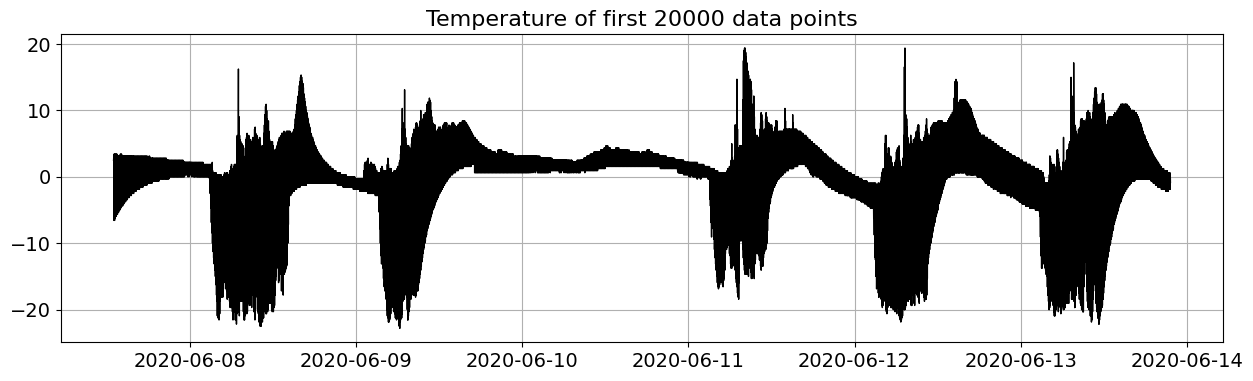

In [5]:
Tp = 20000
plt.figure(figsize=(15,4))
plt.title("Temperature of first {} data points".format(Tp),fontsize=16)
plt.plot(df1['MeasurementDateTime'][:Tp], df1['Value'][:Tp],c='k',lw=1)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

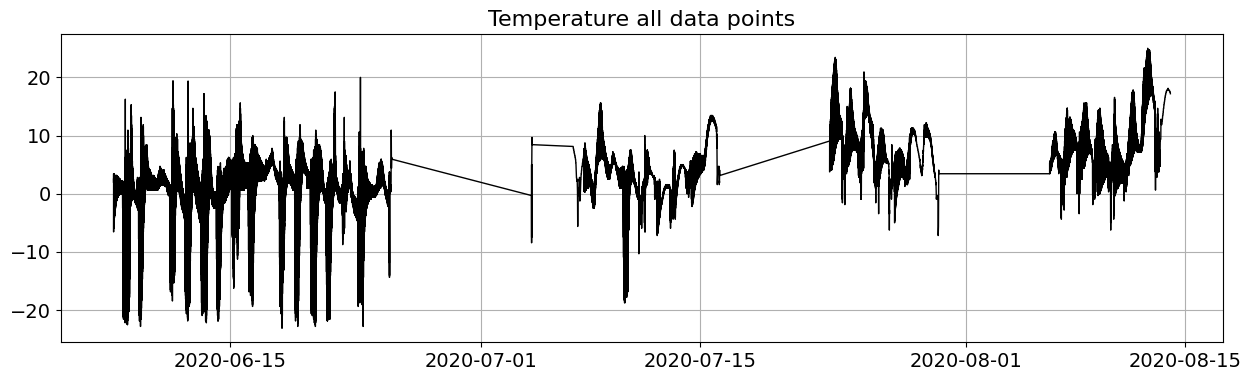

In [6]:
plt.figure(figsize=(15,4))
plt.title("Temperature all data points",fontsize=16)
plt.plot(df1['MeasurementDateTime'], df1['Value'],c='k',lw=1)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done
Epoch number 1050 done
Epoch number 1100 done
Epoch number 1150 done
Epoch number 1200 done
Epoch number 1250 done
Epoch number 1300 done
Epoch number 1350 done
Epoch number 1400 done
Epoch number 1450 done
Epoch number 1500 done
Epoch number 1550 done
Epoch number 1600 done
Epoch number 1650 done
Epoch number 1700 done
Epoch number 1750 done
Epoch number 1800 done
Epoch number 1850 done
Epoch number 1900 done
Epoch number 1950 done
Epoch number 2000 done


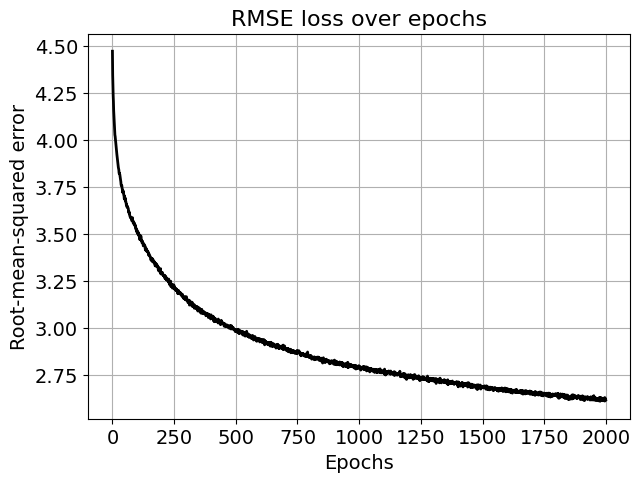

1812/1812 [==============================] - 5s 3ms/step


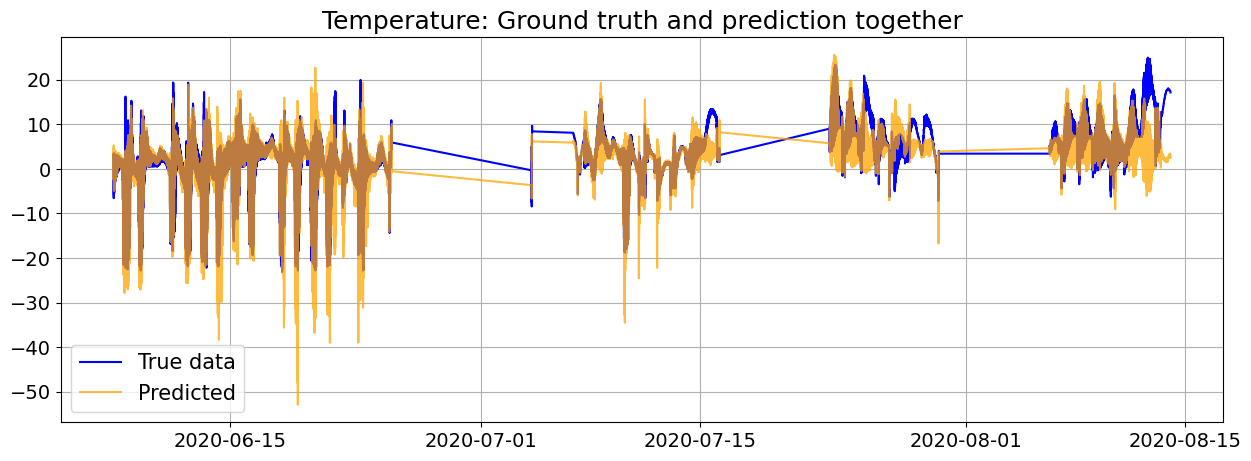

In [8]:
train = np.array(df1['Value'][:Tp])
test = np.array(df1['Value'][Tp:])

train=train.reshape(-1,1)
test=test.reshape(-1,1)

step = 8


def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

def build_simple_rnn(num_units=128, embedding=4,num_dense=32,lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model_temp = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.001)

batch_size = 50
num_epochs = 2000

model_temp.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_temp.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

trainPredict = model_temp.predict(trainX)
testPredict = model_temp.predict(testX)
predicted = np.concatenate((trainPredict,testPredict),axis=0)
index = df1.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together",fontsize=18)
plt.plot(df1['MeasurementDateTime'],df1['Value'],c='blue')
plt.plot(df1['MeasurementDateTime'],predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()